## Library Import

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf


import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

## Data preprocessing

In [2]:
# label tagging to the images

levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "C:/Users/Ashvini Alashetty/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-158.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-10121.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-1811.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-97.png,Normal,../input/covid19-radiography-database/COVID-19...


In [3]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 21165


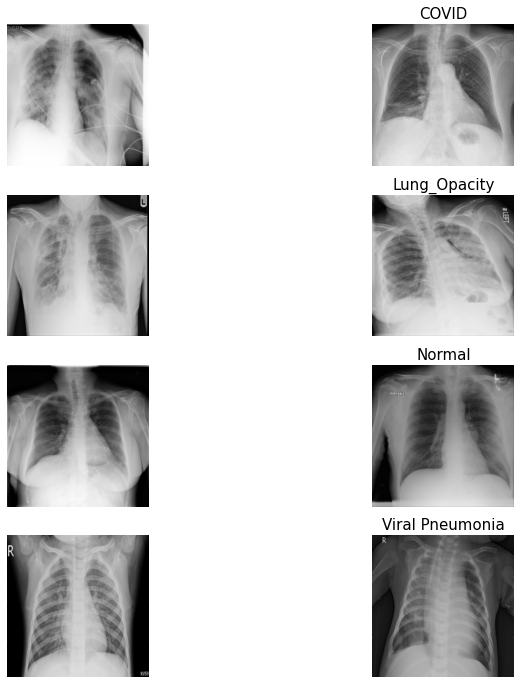

In [4]:
#visualisation 

n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


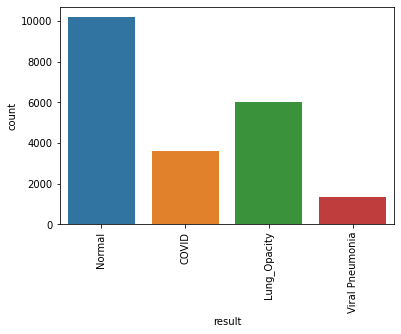

In [5]:
sx = sns.countplot(data['result'])
sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)
plt.show()

In [6]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Opacity : ', list(data['result']).count('Lung_Opacity'))
print('VIral Pneumonia : ', list(data['result']).count('Viral Pneumonia'))
#10192 images sont normales

Normal :  10192
Covid :  3616
Opacity :  6012
VIral Pneumonia :  1345


In [7]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal             48.15
Lung_Opacity       28.41
COVID              17.08
Viral Pneumonia     6.35
Name: result, dtype: float64

In [8]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21165/21165 [02:30<00:00, 141.03it/s]


In [9]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21165, 64, 64, 1) (21165,)


In [10]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#16932 images for train et 4233 for test

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932,)
(4233,)


In [11]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

In [12]:
input_size = X_train.shape[1] * X_train.shape[2]
print(input_size)

num_classes = len(np.unique(y_train))
print(num_classes)

4096
4


In [13]:
# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

## Machine learning models

In [14]:
from sklearn import svm

# Train the SVM
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train,y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)

In [15]:
accuracy_score(y_test, y_pred)

0.830380344909048

In [16]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

print(f"Classification report for classifier {svm_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC():
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2038
           1       0.82      0.65      0.73       723
           2       0.82      0.77      0.79      1203
           3       0.92      0.90      0.91       269

    accuracy                           0.83      4233
   macro avg       0.85      0.81      0.83      4233
weighted avg       0.83      0.83      0.83      4233




In [17]:
from sklearn.ensemble import RandomForestClassifier

# Random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=1)
rf_model.fit(X_train,y_train)

# predict
y_pred = rf_model.predict(X_test)

In [18]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {rf_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.8332152137963619
Classification report for classifier RandomForestClassifier(n_jobs=1):
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2038
           1       0.88      0.69      0.78       723
           2       0.81      0.78      0.79      1203
           3       0.89      0.82      0.85       269

    accuracy                           0.83      4233
   macro avg       0.85      0.80      0.82      4233
weighted avg       0.84      0.83      0.83      4233




In [19]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [20]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {xgb_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.8745570517363572
Classification report for classifier XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...):
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2038
           1       0.92      0.85      0.88       723
           2       0.85      0.81      0.83      1203
  

In [21]:
from sklearn.naive_bayes import MultinomialNB

# Train the MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)

# Evaluate the model
y_pred = nb_model.predict(X_test)

In [22]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")
print(f"Classification report for classifier {nb_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Accuracy: 0.556343019135365
Classification report for classifier MultinomialNB():
              precision    recall  f1-score   support

           0       0.77      0.51      0.61      2038
           1       0.33      0.52      0.41       723
           2       0.63      0.59      0.61      1203
           3       0.37      0.88      0.52       269

    accuracy                           0.56      4233
   macro avg       0.53      0.62      0.54      4233
weighted avg       0.63      0.56      0.57      4233




## MLP

In [23]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# MLP
# preprocessing for x_train
# flatten image 64*64 -> 4096
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

print("x_train type:", type(X_train))
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train type: <class 'numpy.ndarray'>
x_train shape: (16932, 4096)
x_test shape: (4233, 4096)
y_train shape: (16932, 4)
y_test shape: (4233, 4)


In [24]:
# MLP with ReLU and dropout
mlp_model = Sequential()
mlp_model.add(Dense(256, input_dim=input_size))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(num_classes))
mlp_model.add(Activation('softmax'))
mlp_model.summary()

mlp_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
               metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 1,049,860
Trainable params: 1,049,860
Non-trainable params: 0
_________________________________________________________________


In [25]:
start_time = time.time() 
history = mlp_model.fit(X_train, y_train, epochs=50, batch_size=128)
print("Training Time :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 2s 3ms/step - loss: 1.1331 - accuracy: 0.4878
Epoch 2/50
133/133 [==============================] - 1s 4ms/step - loss: 0.9746 - accuracy: 0.5802
Epoch 3/50
133/133 [==============================] - 0s 3ms/step - loss: 0.8992 - accuracy: 0.6332
Epoch 4/50
133/133 [==============================] - 0s 3ms/step - loss: 0.8696 - accuracy: 0.6509
Epoch 5/50
133/133 [==============================] - 0s 3ms/step - loss: 0.8459 - accuracy: 0.6588
Epoch 6/50
133/133 [==============================] - 0s 3ms/step - loss: 0.8306 - accuracy: 0.6723
Epoch 7/50
133/133 [==============================] - 0s 3ms/step - loss: 0.8174 - accuracy: 0.6741
Epoch 8/50
133/133 [==============================] - 0s 3ms/step - loss: 0.8043 - accuracy: 0.6807
Epoch 9/50
133/133 [==============================] - 0s 3ms/step - loss: 0.7935 - accuracy: 0.6844
Epoch 10/50
133/133 [==============================] - 0s 3ms/step - loss: 0.7851 - accuracy: 0.6875

In [26]:
loss, acc = mlp_model.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = mlp_model.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 74.75%


col_0,0,1,2,3
row_0,,,,
0,1805,82,121,30
1,275,320,121,7
2,286,98,794,25
3,12,5,7,245


In [27]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2038
           1       0.63      0.44      0.52       723
           2       0.76      0.66      0.71      1203
           3       0.80      0.91      0.85       269

    accuracy                           0.75      4233
   macro avg       0.74      0.72      0.72      4233
weighted avg       0.74      0.75      0.74      4233




## ConvNet

In [28]:
# Reconstruct 2D matrix 64x64
# 20% for test

X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img, 
                                                    test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

input_shape = (X_train.shape[1],X_train.shape[2],1)

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932, 4)
(4233, 4)


In [29]:
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)       

In [30]:
cnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

start_time = time.time() 
history = cnn_model1.fit(X_train, y_train, epochs=50, batch_size=128)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 12s 29ms/step - loss: 0.8964 - accuracy: 0.6292
Epoch 2/50
133/133 [==============================] - 4s 27ms/step - loss: 0.6724 - accuracy: 0.7320
Epoch 3/50
133/133 [==============================] - 4s 27ms/step - loss: 0.5767 - accuracy: 0.7744
Epoch 4/50
133/133 [==============================] - 4s 27ms/step - loss: 0.5065 - accuracy: 0.8036
Epoch 5/50
133/133 [==============================] - 4s 27ms/step - loss: 0.4681 - accuracy: 0.8203
Epoch 6/50
133/133 [==============================] - 4s 27ms/step - loss: 0.4229 - accuracy: 0.8372
Epoch 7/50
133/133 [==============================] - 4s 27ms/step - loss: 0.4045 - accuracy: 0.8458
Epoch 8/50
133/133 [==============================] - 4s 27ms/step - loss: 0.3789 - accuracy: 0.8575
Epoch 9/50
133/133 [==============================] - 4s 27ms/step - loss: 0.3521 - accuracy: 0.8676
Epoch 10/50
133/133 [==============================] - 4s 27ms/step - loss: 0.3376 - accur

In [31]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 90.86%


col_0,0,1,2,3
row_0,,,,
0,1927,15,89,7
1,27,653,33,10
2,183,10,1005,5
3,8,0,0,261


In [32]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2038
           1       0.96      0.90      0.93       723
           2       0.89      0.84      0.86      1203
           3       0.92      0.97      0.95       269

    accuracy                           0.91      4233
   macro avg       0.92      0.91      0.92      4233
weighted avg       0.91      0.91      0.91      4233




In [33]:
cnn_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235), 
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)       

In [34]:
cnn_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

start_time = time.time() 
history = cnn_model2.fit(X_train, y_train, epochs=50, batch_size=128)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 5s 29ms/step - loss: 1.0959 - accuracy: 0.5311
Epoch 2/50
133/133 [==============================] - 4s 28ms/step - loss: 0.8396 - accuracy: 0.6651
Epoch 3/50
133/133 [==============================] - 4s 28ms/step - loss: 0.7390 - accuracy: 0.7033
Epoch 4/50
133/133 [==============================] - 4s 28ms/step - loss: 0.6920 - accuracy: 0.7224
Epoch 5/50
133/133 [==============================] - 4s 29ms/step - loss: 0.6510 - accuracy: 0.7419
Epoch 6/50
133/133 [==============================] - 4s 29ms/step - loss: 0.6158 - accuracy: 0.7591
Epoch 7/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5736 - accuracy: 0.7790
Epoch 8/50
133/133 [==============================] - 4s 30ms/step - loss: 0.5548 - accuracy: 0.7877
Epoch 9/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5249 - accuracy: 0.7996
Epoch 10/50
133/133 [==============================] - 4s 29ms/step - loss: 0.5079 - accura

In [35]:
loss, acc = cnn_model2.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model2.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 90.67%


col_0,0,1,2,3
row_0,,,,
0,1909,38,86,5
1,13,690,18,2
2,162,43,998,0
3,18,6,4,241


In [36]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report 

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2038
           1       0.89      0.95      0.92       723
           2       0.90      0.83      0.86      1203
           3       0.97      0.90      0.93       269

    accuracy                           0.91      4233
   macro avg       0.92      0.90      0.91      4233
weighted avg       0.91      0.91      0.91      4233


